In [1]:
# Get the data
%run -i "loaddata.py"
all_keys = tuple(data_dict.keys())
keys = [all_keys[i] for i in range(len(all_keys)) if i%2==0]
features = data_dict[all_keys[1]]

# Other loading
plt.rcParams["font.size"] = 13
import scipy.stats as st
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

What is your name? [Simone/Jonathan/Marcus/Runi]Jonathan


#  keras
## Clean data

In [2]:
scale = True

# Clean and put into data_sort
data_sort = []
for key in keys:
    pre_data = []
    for i in range( len(data_dict[key]) ):
        if ( (data_dict[key][i,3:] != 0.).all() ) & ( (np.isnan(data_dict[key][i, :])!=True).all() ):
            pre_data.append( list(data_dict[key][i,:]) )
    data_sort.append(np.array(pre_data))
print("Shapes of different timeseries:",[i.shape for i in data_sort])

if scale:
    for i in range(len(data_sort)):
        scaler = StandardScaler()
        data_sort[i] = scaler.fit_transform(data_sort[i])

Shapes of different timeseries: [(456, 28), (247, 28), (238, 28), (407, 28), (211, 28)]


## Initialize 

In [3]:
def create_timeseries(data, time_size):
    X_series = []
    y_series = []
    # Do it for each timeseries
    for d in data:
        current_X_series = []
        current_y_series = []
        for i in range(len(d)-time_size):
            # Append the window, but do not include features of time, RVS and RVS error (i.e. the first 3)
            current_X_series.append(d[ i:(i+time_size) , [8, 14]])#3:])
            current_y_series.append(d[ i+time_size, 1])
            
        X_series.append( np.asarray(current_X_series) )
        y_series.append( np.asarray(current_y_series) )
    return X_series, y_series

In [4]:
# Number of timestamps in each "window"
n_steps = 20

# Features without "time", "RVS", "RVS_error"
n_features = 2#data_sort[0].shape[1] - 3

In [5]:
X, y = create_timeseries(data_sort, n_steps)
print(sum([len(x) for x in X]))

1459


## Begin model

In [46]:
def begin_model():
    # Define model
    model = Sequential()
    model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_steps, n_features)))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(25, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    # compile the model
    model.compile(optimizer='adam', loss='mse')
    return model

In [47]:
def test_1_timeseries( X, y, index ):
    X_train = np.empty((0, X[0].shape[1], X[0].shape[2]))
    y_train = np.array([])
    for i in range(len(X)):
        if i!=test_index:
            X_train = np.append(X_train, X[i], axis=0)
            y_train = np.append(y_train, y[i])
        
    X_test = X[index]
    y_test = y[index]
    return X_train, X_test, y_train, y_test

In [48]:
test_index = 1
X_train, X_test, y_train, y_test = test_1_timeseries(X, y, test_index)

In [49]:
model = begin_model()
history = model.fit(X_train, y_train, epochs=1000, verbose=0, validation_data=(X_test, y_test))
y_pred = model.predict(X_test)[:,0]

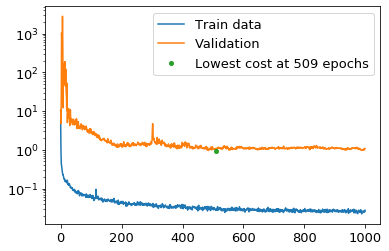

In [50]:
plt.figure()
plt.semilogy(history.history["loss"], label="Train data")
plt.semilogy(history.history["val_loss"],label="Validation")
plt.plot(np.argmin(history.history["val_loss"]), min(history.history["val_loss"]), '.', 
         ms=8 ,label="Lowest cost at {} epochs".format(np.argmin(history.history["val_loss"])))
plt.legend()
plt.show()

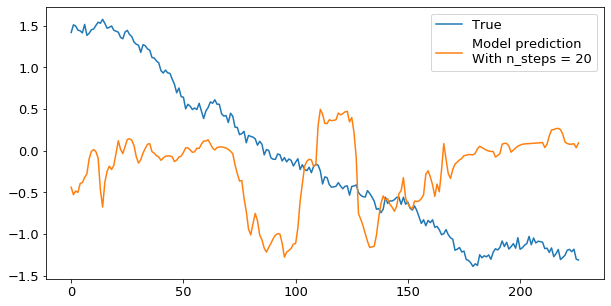

In [51]:
index = np.arange(0,len(y_test))
plt.figure(figsize=(10,5))
plt.plot(y_test, label="True")
plt.plot(y_pred, label="Model prediction\nWith n_steps = {}".format(n_steps))
plt.legend()
plt.show()

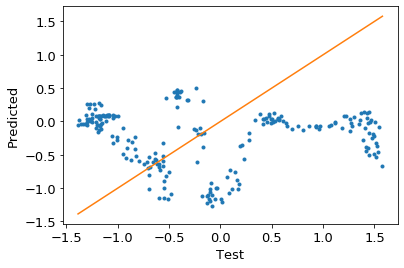

In [52]:
plt.plot(y_test, y_pred,'.')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.xlabel("Test"); plt.ylabel("Predicted")
plt.show()